## Import Libraries

In [ ]:
import nltk
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
pd.set_option('display.max_colwidth', 300)


## Prepare Stopwords
We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Clean up the Comment Data
Clean up the comment data from both YouTube and Reddit

In [ ]:
# Load data files
youtube_df = pd.read_csv('./comments_Youtube.csv')
reddit_df = pd.read_csv('./comments_Reddit.csv')

### 1.1  Tranlaste into English
there are some comments wrote in other language, the fisrt step we need to do is translating it into English.

In [ ]:
from googletrans import Translator
translator = Translator()
def translate(row):
    if row.name%100==0:
        print(row.name)
    translation = translator.translate(row['comment'], dest='en')
    return translation.text

df['comment_en'] = df.apply(translate,axis=1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
reddit_df = reddit_df[['comment']].rename({'comment':'comment_en'},axis=1)

df = pd.concat([youtube_df[['comment_en']],reddit_df[['comment_en']]])
df.to_csv("reddit_youtube_comments.csv",index=False)

### 1.2 Remove the URL, email, and new line characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [ ]:
# Convert to list
data = df.comment_en.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data = [re.sub(r'http\S+', '', text) for text in data]
data = [re.sub(r'www\.\S+', '', text) for text in data]

pprint(data[:1])

['Lectron CCS to Tesla Adapter :  Dual-Level Tesla Charger:  (Amazon) CCS to '
 'Tesla Adapter: ']


In [ ]:
# Convert to csv and save
pd.DataFrame(data,columns=['comment']).to_csv('reddit_youtube_cleaned.csv',index=False)

### 1.3 Tokenize words and Clean-up text

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

### 1.4 Creating Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### 1.5 Remove Stopwords, Make Bigrams and Lemmatize

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#! python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:3])

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2)], [(15, 1), (30, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 2), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)]]


## Building the Topic Model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using _lda_model.print_topics()_ as shown next.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.288*"model" + 0.102*"new" + 0.098*"good" + 0.082*"suspension" + '
  '0.078*"range" + 0.045*"experience" + 0.028*"lose" + 0.023*"comfortable" + '
  '0.017*"upgrade" + 0.013*"become"'),
 (1,
  '0.088*"love" + 0.070*"delivery" + 0.065*"wheel" + 0.039*"leave" + '
  '0.037*"option" + 0.036*"fast" + 0.035*"fix" + 0.032*"show" + 0.026*"minute" '
  '+ 0.026*"market"'),
 (2,
  '0.216*"want" + 0.147*"pay" + 0.109*"test" + 0.047*"available" + '
  '0.016*"entire" + 0.008*"ioniq" + 0.000*"ev" + 0.000*"hit" + 0.000*"order" + '
  '0.000*"part"'),
 (3,
  '0.162*"drive" + 0.088*"think" + 0.078*"also" + 0.049*"even" + '
  '0.035*"pretty" + 0.035*"keep" + 0.027*"road" + 0.026*"sell" + 0.024*"add" + '
  '0.024*"live"'),
 (4,
  '0.215*"car" + 0.148*"tesla" + 0.071*"go" + 0.040*"take" + 0.035*"people" + '
  '0.035*"time" + 0.033*"buy" + 0.032*"still" + 0.028*"year" + 0.022*"long"'),
 (5,
  '0.108*"charger" + 0.082*"little" + 0.078*"speed" + 0.065*"normal" + '
  '0.043*"expect" + 0.036*"handle" + 0

## Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -15.535709764424842

Coherence Score:  0.40708951646184216


## Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [ ]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/xu/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.333595 -0.322528       1        1  19.913119
9      0.194150  0.265598       2        1  12.037788
3      0.135550  0.081743       3        1  10.692411
10     0.160441  0.129879       4        1  10.434067
8      0.112023  0.053802       5        1   9.670528
1      0.006277 -0.002875       6        1   5.153736
0      0.004202 -0.002452       7        1   4.844915
13    -0.057242 -0.015776       8        1   3.540416
7     -0.051866 -0.015037       9        1   3.500988
17    -0.044238 -0.013681      10        1   3.337979
11    -0.079045 -0.018463      11        1   2.789767
14    -0.113545 -0.020698      12        1   2.598960
6     -0.080586 -0.018561      13        1   2.376886
15    -0.091307 -0.019570      14        1   2.351376
12    -0.094383 -0.019660      15        1   1.999485
16    -0.105443 -0.020332      16        1   1.847086
5     -0.117128 -0.020782      17        1   1.516558
2     -0.111454 -0.020609      18        1   1.393936, topic_info=        Term         Freq        Total Category  logprob  loglift
48       car  2954.000000  2954.000000  Default  30.0000  30.0000
17       get  1634.000000  1634.000000  Default  29.0000  29.0000
3      tesla  2040.000000  2040.000000  Default  28.0000  28.0000
188    model   965.000000   965.000000  Default  27.0000  27.0000
214    drive  1200.000000  1200.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1199   place     0.060324     1.551429  Topic18  -9.6781   1.0258
2496  window     0.060322     1.550869  Topic18  -9.6781   1.0262
975    build     0.060324     1.552463  Topic18  -9.6781   1.0252
1668   stack     0.060327     1.554729  Topic18  -9.6780   1.0238
838      big     0.060321     1.553950  Topic18  -9.6781   1.0242

[760 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
165       1  0.983771        able
729       4  0.984100  absolutely
695       2  0.985662      accept
670      10  0.956821      action
164      12  0.989890    actually
...     ...       ...         ...
95        5  0.997148        work
96        2  0.984913       world
130       3  0.987432       worth
212       6  0.981594       write
40        1  0.995783        year

[371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 4, 11, 9, 2, 1, 14, 8, 18, 12, 15, 7, 16, 13, 17, 6, 3])

##  Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to _gensim.models.wrappers.LdaMallet_. See how I have done this below.

In [ ]:
# Install Libraries
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-03-15 23:15:21--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-03-15 23:15:21--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  1.22MB/s    in 13s     

2023-03-15 23:15:35 (1.18 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

/bin/bash: unzip: command not found


/home/xu/.local/lib/python3.8/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.49710055 -6.80999197 -6.2424158  ... -3.10768368 -3.06431666
  -2.93006612]
 [ 0.3755868  -7.49850145 -6.93092528 ... -3.79619316 -3.75282614
  -3.6185756 ]
 [ 0.82554996 -1.51673701 -7.3327533  ... -4.19802118 -4.15465416
  -4.02040362]
 ...
 [-1.76510338 -1.08830953 -0.52073456 ...  2.61398205  2.65734907
   2.79159961]
 [-1.76511746 -1.08830544 -0.52072991 ...  2.61399445  2.65736148
   2.79161202]
 [-1.76512602 -1.08830559 -0.52070695 ...  2.61399543  2.65736245
   2.79161299]] loaded from the file /dev/shm/joblib_memmapping_folder_17845_7525a8a16c914792bafc50ecfc225404_84514d6640dc4b4ea797c5b7c0d23a76/17845-139853962167392-3a39547a78374b74a8badac7dd20f6e6.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See ht

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
from gensim.models.wrappers.ldamallet import LdaMallet

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=18,id2word=id2word)

Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 302
total tokens: 55988
<10> LL/token: -9.67817
<20> LL/token: -9.264
<30> LL/token: -9.06828
<40> LL/token: -8.90972

0	2.77778	change good cost add make tesla include model information rate maintenance channel button total open wait lose fuel range steering_wheel 
1	2.77778	tesla drive build quality reason time week buy evs minute person window offer manufacturer car part day full trade station 
2	2.77778	love work performance car compare money ride put cool kind family bolt people stuff acceleration brand big amount drive friend 
3	2.77778	car driver back fsd autopilot camera feel front drive close amazing nice rear update stay upgrade bad sensor completely future 
4	2.77778	year month car turn great issue find ve make range experience tesla lol start update talk happy production km lane 
5	2.77778	car buy vehicle make drive cheap brake long due set live lease easy road deal mine trim pedal gas stock 
6	2

In [ ]:
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('driver', 0.0460546515198035),
   ('happen', 0.03530856616518269),
   ('turn', 0.030089038992938286),
   ('steering_wheel', 0.026097635861221984),
   ('brake', 0.02579060485108996),
   ('control', 0.021492170709241632),
   ('speed', 0.01934295363831747),
   ('break', 0.01903592262818545),
   ('side', 0.018114829597789376),
   ('hand', 0.016886705557261284)]),
 (2,
  [('drive', 0.05324211778703153),
   ('great', 0.03837001784651993),
   ('good', 0.03242117787031529),
   ('feel', 0.028554431885782272),
   ('seat', 0.02795954788816181),
   ('love', 0.02706722189173111),
   ('phone', 0.022605591909577633),
   ('screen', 0.01903628792385485),
   ('fun', 0.018738845925044618),
   ('ride', 0.01814396192742415)]),
 (16,
  [('model', 0.19322375041932238),
   ('range', 0.03622945320362295),
   ('hear', 0.023817510902381753),
   ('bit', 0.019792016101979202),
   ('today', 0.019456558201945657),
   ('nice', 0.01777926870177793),
   ('top', 0.016437437101643745),
   ('expect', 0.0161019792

In [ ]:
df_list = []

for topic,detail in ldamallet.show_topics(formatted=False):
    df = pd.DataFrame(detail,columns=[f"t_{topic}",f"t_{topic}_v"])
    df_list.append(df)
pd.concat(df_list,axis=1)

,t_17,t_17_v,t_2,t_2_v,t_1,t_1_v,t_9,t_9_v,t_11,t_11_v,t_7,t_7_v,t_16,t_16_v,t_6,t_6_v,t_5,t_5_v,t_12,t_12_v
0,battery,0.069767,drive,0.053242,good,0.095238,driver,0.046055,charge,0.097313,car,0.275108,model,0.193224,mile,0.056677,buy,0.084069,wheel,0.056559
1,power,0.037084,great,0.038370,tesla,0.071759,happen,0.035309,long,0.037015,experience,0.044084,range,0.036229,tire,0.040059,people,0.081780,wait,0.046678
2,system,0.028913,good,0.032421,day,0.059193,turn,0.030089,time,0.034328,bad,0.042758,hear,0.023818,drive,0.038576,car,0.055937,order,0.044293
3,pretty,0.016656,feel,0.028554,time,0.049603,steering_wheel,0.026098,fast,0.028358,amazing,0.024528,bit,0.019792,ve,0.035312,vehicle,0.054956,delivery,0.029302
4,home,0.016028,seat,0.027960,give,0.047619,brake,0.025791,leave,0.020896,thing,0.024196,today,0.019457,car,0.035015,option,0.021263,hope,0.028620
5,case,0.015399,love,0.027067,work,0.041997,control,0.021492,work,0.019701,rent,0.020550,nice,0.017779,cost,0.034718,electric,0.018973,week,0.024872
6,level,0.014771,phone,0.022606,part,0.021825,speed,0.019343,trip,0.018806,fuck,0.019224,top,0.016437,cheap,0.033234,idea,0.018646,back,0.021465
7,completely,0.014456,screen,0.019036,owner,0.019841,break,0.019036,charger,0.018209,hate,0.015247,expect,0.016102,replace,0.023145,lease,0.018646,change,0.021465
8,number,0.013514,fun,0.018739,bring,0.017526,side,0.018115,change,0.018209,build_quality,0.014253,half,0.013418,set,0.021958,electric_car,0.017337,call,0.020102
9,motor,0.012885,ride,0.018144,offer,0.015873,hand,0.016887,difference,0.017910,absolutely,0.014253,early,0.013083,run,0.021958,family,0.016683,update,0.017036


## find the optimal number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=9, step=1)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 302
total tokens: 55988
<10> LL/token: -8.51149
<20> LL/token: -8.3925
<30> LL/token: -8.32863
<40> LL/token: -8.29041

0	25	car tesla drive video model good great make love work buy battery driver ev time big thing people feel charge 
1	25	car tesla model charge drive mile price year make day time good cost lot issue wheel people wait vehicle experience 

<50> LL/token: -8.26001
<60> LL/token: -8.23509
<70> LL/token: -8.21964
<80> LL/token: -8.21062
<90> LL/token: -8.19362

0	25	tesla car video model great people make good love drive time driver work ev lot big battery happen thing high 
1	25	car drive model charge year buy day issue mile good price make bad cost tesla range battery wait put wheel 

<100> LL/token: -8.18682
<110> LL/token: -8.17463
<120> LL/token: -8.16056
<130> LL/token: -8.15266
<140> LL/token: -8.15358

0	25	car tesla video love great people make model good lot driver vehicle ev big happen hi

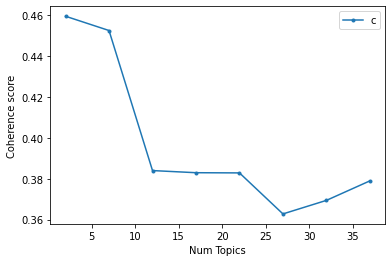

In [ ]:
import matplotlib.pyplot as plt

# Show graph
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values,'.-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### narrow the range of topic numbers to get the best coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=3)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 302
total tokens: 55988
<10> LL/token: -8.52432
<20> LL/token: -8.41266
<30> LL/token: -8.35458
<40> LL/token: -8.31413

0	25	car tesla video good charge model love time mile day buy work year make back ev thing give test part 
1	25	car drive model tesla make people price battery lot wheel great long tire vehicle year pay bad ve put wait 

<50> LL/token: -8.27271
<60> LL/token: -8.2402
<70> LL/token: -8.21992
<80> LL/token: -8.20956
<90> LL/token: -8.20014

0	25	tesla car good video charge model love time day mile bad battery back ev order give nice make test power 
1	25	car drive make model great year vehicle price people lot work thing issue buy wheel cost wait ve tire pay 

<100> LL/token: -8.17951
<110> LL/token: -8.17623
<120> LL/token: -8.16726
<130> LL/token: -8.16241
<140> LL/token: -8.1507

0	25	tesla car good video charge make love model time battery day thing back give ev order nice test change bad 
1	

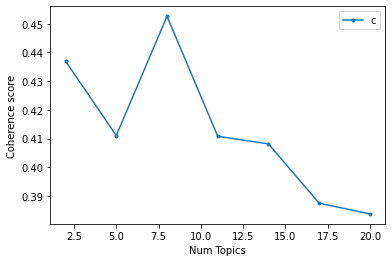

In [ ]:
import matplotlib.pyplot as plt

# Show graph
start=2;limit=22;step=3
x = range(start, limit, step)
plt.plot(x, coherence_values,'.-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
list(x)

[2, 5, 8, 11, 14, 17, 20]

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.437
Num Topics = 5  has Coherence Value of 0.411
Num Topics = 8  has Coherence Value of 0.4526
Num Topics = 11  has Coherence Value of 0.4108
Num Topics = 14  has Coherence Value of 0.4082
Num Topics = 17  has Coherence Value of 0.3875
Num Topics = 20  has Coherence Value of 0.3838


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(num_words=20,formatted=False)
for i,keywords in sorted(model_topics):
    print(f"Topic{i}: {','.join([key for key,weight in keywords])}")


Topic0: tesla,people,thing,put,interesting,elon,real,fall,hear,fuck,call,read,technology,electric_car,person,looks_like,wrong,force,accident,understand
Topic1: mile,cost,tire,part,cheap,vehicle,ev,year,fix,replace,full,small,service,issue,work,repair,include,add,check,gas
Topic2: good,great,work,car,nice,feel,point,live,talk,cool,give,place,idea,electric,tech,bring,family,minute,plaid,hate
Topic4: car,lot,range,experience,make,performance,seat,option,compare,run,pretty,big,interior,great,ride,super,suspension,level,side,long
Topic5: charge,battery,tesla,power,high,problem,fast,home,speed,low,due,charger,km,change,lose,supercharger,rate,case,great_video,evs
Topic6: drive,time,back,find,leave,stop,brake,camera,front,normal,road,close,rear,screen,bad,bit,miss,hit,agree,trip
Topic7: video,test,guy,post,show,hope,enjoy,review,question,lol,watch,comment,happy,congratulation,man,share,channel,learn,information,true
Topic8: make,year,vehicle,update,system,build,software,start,company,end,futur

## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The _format_topics_sentences()_ function below nicely aggregates this information in a presentable table.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13,0.0511,"tesla, option, motor, correct, simply, condition, huge, announce, driving, notice",Lectron CCS to Tesla Adapter : Dual-Level Tesla Charger: (Amazon) CCS to Tesla Adapter:
1,1,0,0.1028,"people, car, experience, guy, bring, engine, deal, arrive, nice, rental","I was a landlord for 20 years and this sounds exactly like my experience. If dealing with difficult renters and abusive situations doesnt really bother you too much, you can make money doing this over time. For most folks, however, you just get tired of engaging with messed up people who have th..."
2,2,2,0.0911,"software, difference, compare, idea, magic_dock, rate, interest, entire, live, mention","Really interesting video, great to see more details on how something like Turo works for the longer term. As a consumer, I rented from Turo once (to test drive a MY before I got mine) and it was a great experience. The host was SUPER nice and even contacted Turo on my behalf when I screwed up an..."
3,3,8,0.0679,"battery, station, swap, long, fact, minute, great_video, force, future, route",This sounds like a nightmare of a business. Kudos to you for doing it for that long of a time despite all the issues.
4,4,0,0.1665,"people, car, experience, guy, bring, engine, deal, arrive, nice, rental","I only got through 6 trips on my 2019 model 3 on Turo before I pulled it. The hassle of dealing with irresponsible drivers and battling with TURO to get compensated for guest extra charges was making me feel the projected value was not worth the time. Mostly, came down to last guest that smoked ..."
...,...,...,...,...,...
1700,1700,10,0.0542,"good, greeting, level, comparison, excellent, finish, surprised, eduardo, load, long_live","This guy was born to make comparisons, very, very good"
1701,1701,26,0.0553,"model, buy, question, review, grefg, half, budget, family, balanced, rim",Congratulations girls. You did great. What an acceleration in the Tesla. It hurts that it is not suitable for all budgets
1702,1702,22,0.0429,"wheel, performance, range, mile, version, ride, tire, set, play, suspension",Excellent I liked the performance of Tesla ... great video
1703,1703,3,0.0544,"tesla, high, super, low, current, due, view, generation, technical, short","Very good and concise comparison, Joan. By design I would stay with the Mustang, but due to the practicality of the superchargers and because it brings practically everything imaginable, my decision leans towards the Tesla."


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.1665,"people, car, experience, guy, bring, engine, deal, arrive, nice, rental","I only got through 6 trips on my 2019 model 3 on Turo before I pulled it. The hassle of dealing with irresponsible drivers and battling with TURO to get compensated for guest extra charges was making me feel the projected value was not worth the time. Mostly, came down to last guest that smoked ..."
1,1,0.1099,"tesla, year, ev, production, worth, fall, engineer, improvement, general, focus",Lithium based batteries are not ecological because they need mining and millions of gallons of water to transform the lithium. Lithium based batteries are not the solution for the billions EVS. Quality built is another topic why Teslas are overrated for their costs. Teslas have been built for 20...
2,2,0.3308,"software, difference, compare, idea, magic_dock, rate, interest, entire, live, mention","At 15:18, you mention interest in comparing with a Long Range. Dave, I might be able to help you with some testing, as I live in Connecticut (we met at the IONIQ 5 filming in Tolland, and at the Pipistrel electric plane event in Waterbury), and I have a 2018 Model 3 Long Range, and an OBD dongle..."
3,3,0.3792,"tesla, high, super, low, current, due, view, generation, technical, short","The main reason (without getting super technical) as to why Tesla V3 charge slower on 800V EVs is due to Teslas current superchargers being 400V architeture, whereas EAs and some other high speed chargers are 800V architecture, meaning they dont need to supply super high amperage to supercharge ..."
4,4,0.1042,"test, work, interesting, content, expect, easy, tesla_model, open, read, excited","almost 60k subs on content theft. #ContentTheftWorks! Even more hilarious though, is you watermark the center of the video with your own logo on another mans content and dont even TRY to hid the theft by only zooming in half the distance needed to hide Sandys own identification graphic"
5,5,0.1459,"drive, today, sensor, base, parking, pretty, range, phantom, ultrasonic_sensor, regulate","I loved the ultrasonic sensors and radar adaptive cruise control on my VW Egolf. Never failed me, and very few phantom breaking events over 60,000 miles driven. My new Tesla has neither. Parking it without ultrasonics feels barbaric; the lack of rear cross traffic alerts is disconcerting- especi..."
6,6,0.3898,"power, cool, increase, heat, heat_pump, temperature, air, work, house, efficiency","Heat pumps have been around for decades. Theyve been getting better over the years as well. Present day heat pumps can achieve a coefficient of performance (COP) of 5. This translates to 500% efficiency. Very impressive, but heat pump COP drops as the temperature difference (inside air temp - ou..."
7,7,0.1688,"thing, system, night, remember, moment, elon, post, present, lead, implement","Great summary Ryan, thanks! I have found the same issue with using AP on congested roads.This illustrates one of the obstacles to implementing a fully autonomous vehicles IMO. These systems are adaptive but not predictive. You and I can look at our environment and what’s happening. Our minds can..."
8,8,0.2166,"battery, station, swap, long, fact, minute, great_video, force, future, route","Great video. Very interesting. Im curious that, whats the cost difference between battery swapping and rapid charging? Also, are NIO battery swaps common enough to make a long trip convenient? Or are you forced to deviate from your route or forced to take a route that has a swapping stations. I ..."
9,9,0.2015,"vehicle, electric, design, build, technology, hope, impressive, reliability, great_review, rivian","Since my recent retirement, I have been considering getting an electric vehicle and your review is exactly what I needed to hear. If it werent for innovators like Elon Musk, many of the conveniences that we take for granted today would have never happened. Frankly, I believe he is on the right t..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The _Perc_Contribution_ column is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6,"car, bike, buy, ride, drive, engine, price, ro...",572.0,0.0506
1,2,"drive, card, problem, system, driver, work, bi...",780.0,0.0689
2,10,"write, article, line, organization, thing, opi...",1378.0,0.1218
3,9,"line, nntp_poste, host, organization, reply, w...",298.0,0.0263
4,18,"file, line, problem, program, read, set, chang...",197.0,0.0174
...,...,...,...,...
11309,17,"drug, problem, study, food, effect, doctor, re...",NaN,NaN
11310,2,"drive, card, problem, system, driver, work, bi...",NaN,NaN
11311,2,"drive, card, problem, system, driver, work, bi...",NaN,NaN
11312,18,"file, line, problem, program, read, set, chang...",NaN,NaN
